In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from sklearn.cluster import KMeans

In [137]:
df1 = pd.read_csv('../data/week_data/data/California_spring_20120401-20120407新.csv')

In [138]:
weed_speed1 = df1['wind speed at 100m (m/s)']
weed_speed1

0       14.386
1       13.992
2       14.316
3       13.440
4       12.872
         ...  
1003    10.610
1004    10.504
1005    10.861
1006    11.221
1007    11.318
Name: wind speed at 100m (m/s), Length: 1008, dtype: float64

<IPython.core.display.Javascript object>


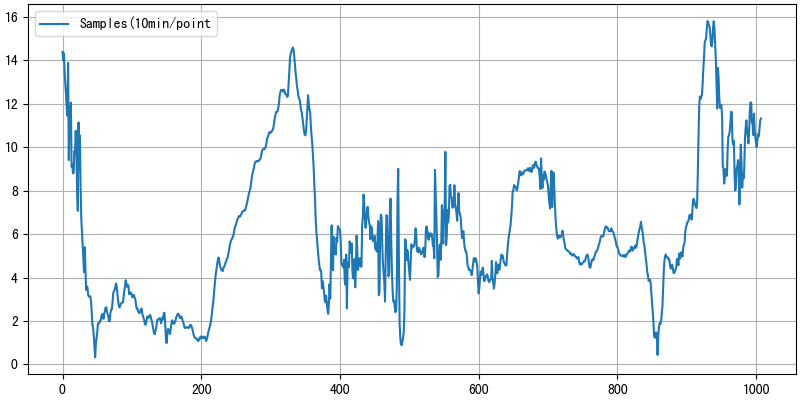

In [139]:
fig1, ax1 = plt.subplots(figsize=(8, 4), layout='constrained')
ax1.plot(weed_speed1,label='Samples(10min/point') 
ax1.legend() 
ax1.grid()
plt.show()

In [140]:
weed_speed1.shape

(1008,)

In [141]:
weed_speed1 = np.array(weed_speed1).reshape(-1,1)
weed_speed1

array([[14.386],
       [13.992],
       [14.316],
       ...,
       [10.861],
       [11.221],
       [11.318]])

In [142]:
kmeans1 = KMeans(n_clusters=10, random_state=1,).fit(weed_speed1)

In [143]:
labels = kmeans1.labels_
labels,labels.shape

(array([5, 5, 5, ..., 8, 8, 8], dtype=int32), (1008,))

<IPython.core.display.Javascript object>


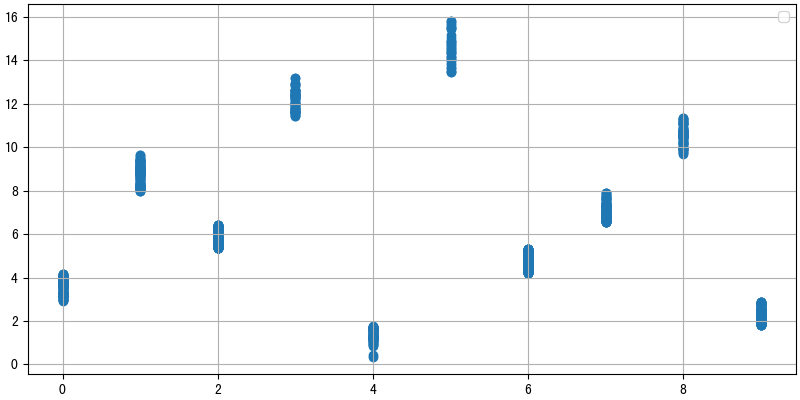

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [144]:
fig2, ax2 = plt.subplots(figsize=(8, 4), layout='constrained')
ax2.scatter(labels,weed_speed1)
ax2.legend() 
ax2.grid()
plt.show()

In [145]:
n_clusters=10
width = []
speed = weed_speed1.reshape(-1)
for x in range(n_clusters):
    count = []
    for idx,label in enumerate(labels):
        if label == x:
            count.append(speed[idx])
    count = np.array(count)
    std = np.std(count)
    # %95的置信区间宽度
    alpha = 1.96 * std 
    width.append(alpha)
    print(count.shape)

(90,)
(112,)
(152,)
(60,)
(70,)
(35,)
(220,)
(87,)
(67,)
(115,)


In [146]:
width

[0.6969948691914525,
 0.843192090299565,
 0.6400187624872681,
 0.9050364018422438,
 0.5710164119672919,
 1.390477298104503,
 0.6111537928428071,
 0.7316493985748805,
 0.8701605172430933,
 0.6099021914632934]

In [147]:
centers = kmeans1.cluster_centers_
centers

array([[ 3.5627033 ],
       [ 8.78859821],
       [ 5.85036364],
       [12.16356667],
       [ 1.34472857],
       [14.59217143],
       [ 4.795621  ],
       [ 7.09801149],
       [10.55535821],
       [ 2.25738938]])

In [148]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam, SGD

In [149]:
def set_tf_device(device):
    if device == 'cpu':
        print("Training on CPU...")
        os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
        os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
    elif device == 'gpu':
        gpus = tf.config.experimental.list_physical_devices("GPU")
        # 前面一直用的第一张卡跑，一次性跑不了这么多个程序，换到第三张卡跑
        tf.config.set_visible_devices(gpus[3], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[3], True)
        print("Training on GPU...")
set_tf_device('gpu')

Training on GPU...


In [150]:
 # define model
model = Sequential()
model.add(Input(shape=(9, 1)))
model.add(GRU(16, return_sequences=False))
# model.add(Dense(16, kernel_initializer='he_normal', activation='relu'))
# model.add(Dense(8, kernel_initializer='he_normal', activation='relu'))
# model.add(Dense(4, kernel_initializer='he_normal', activation='relu'))
model.add(Dense(1, kernel_initializer='he_normal'))
# 对学习率很敏感
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

In [151]:
seq_len = 9

In [152]:
result = []
for index in range(len(weed_speed1) - seq_len):
    result.append(weed_speed1[index:index + seq_len + 1])  # create train label
# 划分训练集和测试集 (测试集为两天，风能间隔为10min,两天=6*24*2=288)
result = np.array(result)  # 用numpy对其进行矩阵化
row = int(result.shape[0] * (1 - 288 / result.shape[0]))
x_train = result[:row, :-1]
y_train = result[:row, -1]
x_test = result[row:, :-1]
y_test = result[row:, -1]

In [153]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((711, 9, 1), (711, 1), (288, 9, 1), (288, 1))

In [154]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
# fit the model
model.fit(x_train, y_train, epochs=200, batch_size=64, validation_split=0.1, verbose=1, callbacks=[callback])

Epoch 1/200
10/10 [==============================] - 2s 59ms/step - loss: 37.7510 - val_loss: 46.2056
Epoch 2/200
10/10 [==============================] - 0s 18ms/step - loss: 19.4268 - val_loss: 26.2093
Epoch 3/200
10/10 [==============================] - 0s 17ms/step - loss: 12.1248 - val_loss: 14.6012
Epoch 4/200
10/10 [==============================] - 0s 17ms/step - loss: 8.1083 - val_loss: 8.6264
Epoch 5/200
10/10 [==============================] - 0s 17ms/step - loss: 5.4793 - val_loss: 3.7988
Epoch 6/200
10/10 [==============================] - 0s 17ms/step - loss: 3.6339 - val_loss: 1.5394
Epoch 7/200
10/10 [==============================] - 0s 18ms/step - loss: 2.6032 - val_loss: 0.6497
Epoch 8/200
10/10 [==============================] - 0s 17ms/step - loss: 1.9088 - val_loss: 0.2752
Epoch 9/200
10/10 [==============================] - 0s 17ms/step - loss: 1.4807 - val_loss: 0.2265
Epoch 10/200
10/10 [==============================] - 0s 16ms/step - loss: 1.2187 - val_loss: 

10/10 [==============================] - 0s 17ms/step - loss: 0.3420 - val_loss: 0.1928
Epoch 83/200
10/10 [==============================] - 0s 17ms/step - loss: 0.3421 - val_loss: 0.1853
Epoch 84/200
10/10 [==============================] - 0s 17ms/step - loss: 0.3413 - val_loss: 0.1965
Epoch 85/200
10/10 [==============================] - 0s 27ms/step - loss: 0.3460 - val_loss: 0.2254
Epoch 86/200
10/10 [==============================] - 0s 17ms/step - loss: 0.3413 - val_loss: 0.2169
Epoch 87/200
10/10 [==============================] - 0s 18ms/step - loss: 0.3405 - val_loss: 0.2429
Epoch 88/200
10/10 [==============================] - 0s 19ms/step - loss: 0.3373 - val_loss: 0.1936
Epoch 89/200
10/10 [==============================] - 0s 16ms/step - loss: 0.3408 - val_loss: 0.2374
Epoch 90/200
10/10 [==============================] - 0s 17ms/step - loss: 0.3472 - val_loss: 0.2562
Epoch 91/200
10/10 [==============================] - 0s 17ms/step - loss: 0.3935 - val_loss: 0.4405
Epo

In [155]:
predict_lstm = model.predict(x_test)
print(predict_lstm.shape)

(288, 1)


<IPython.core.display.Javascript object>


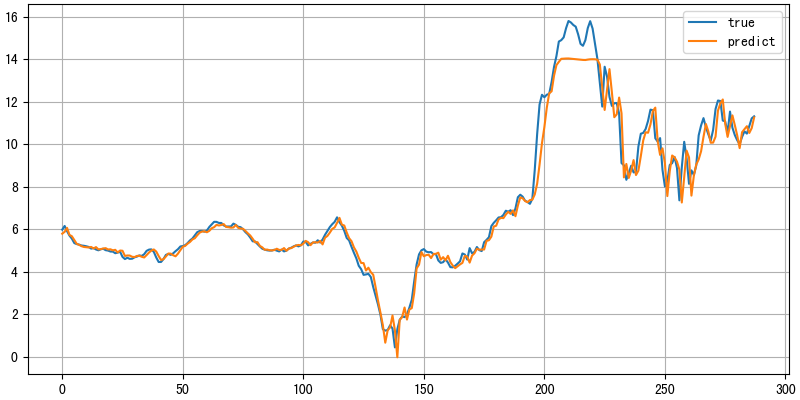

In [156]:
fig, ax = plt.subplots(figsize=(8, 4), layout='constrained')
ax.plot(y_test, label='true')
ax.plot(predict_lstm, label='predict')
ax.grid()
ax.legend()
plt.show()

In [157]:
# 开始计算区间
# predict_lstm.shape
# for i in range(predict_lstm.shape[0]):
#     kmeans1.predict
predict_lstm = np.array(predict_lstm).astype('float')
predict_class = kmeans1.predict(predict_lstm)
predict_class

array([2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 6, 2, 2, 2, 2, 6, 2,
       2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 0, 6, 0, 0, 0, 9,
       9, 4, 4, 4, 4, 9, 4, 4, 4, 9, 9, 4, 9, 9, 0, 0, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       2, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1,
       1, 8, 8, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 3, 3, 3, 5, 3, 8, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 8,
       8, 8, 8, 3, 3, 8, 1, 8, 1, 7, 1, 1, 1, 1, 1, 7, 1, 8, 1, 7, 1, 1,
       1, 1, 8, 8, 8, 8, 8, 8, 3, 3, 3, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8,
       8, 8], dtype=int32)

In [158]:
up = []
down = []
for idx, predict in enumerate(predict_lstm):
    a = width[predict_class[idx]]
    up.append(predict[0] + a)
    down.append(predict[0] - a)
    print(predict[0],a,predict[0] + a,predict[0] - a)

5.790293216705322 0.6400187624872681 6.430311979192591 5.150274454218054
5.878891944885254 0.6400187624872681 6.518910707372522 5.2388731823979855
6.064622402191162 0.6400187624872681 6.7046411646784305 5.424603639703894
5.733549118041992 0.6400187624872681 6.373567880529261 5.093530355554724
5.670569896697998 0.6400187624872681 6.3105886591852665 5.03055113421073
5.489650726318359 0.6400187624872681 6.129669488805628 4.849631963831091
5.3160905838012695 0.6111537928428071 5.927244376644077 4.704936790958462
5.267215728759766 0.6111537928428071 5.878369521602573 4.656061935916958
5.202446937561035 0.6111537928428071 5.813600730403842 4.591293144718228
5.165303707122803 0.6111537928428071 5.77645749996561 4.5541499142799955
5.153148651123047 0.6111537928428071 5.764302443965854 4.54199485828024
5.140756130218506 0.6111537928428071 5.751909923061313 4.529602337375699
5.1668877601623535 0.6111537928428071 5.778041553005161 4.555733967319546
5.093172550201416 0.6111537928428071 5.704326343

9.811993598937988 0.8701605172430933 10.682154116181081 8.941833081694895
9.098899841308594 0.843192090299565 9.942091931608159 8.255707751009028
7.561431407928467 0.7316493985748805 8.293080806503347 6.829782009353586
8.735075950622559 0.843192090299565 9.578268040922124 7.891883860322993
9.473206520080566 0.843192090299565 10.316398610380132 8.630014429781001
9.388568878173828 0.843192090299565 10.231760968473393 8.545376787874263
9.185181617736816 0.843192090299565 10.028373708036382 8.341989527437251
8.806910514831543 0.843192090299565 9.650102605131108 7.963718424531978
7.259298801422119 0.7316493985748805 7.990948199997 6.5276494028472385
8.452252388000488 0.843192090299565 9.295444478300054 7.609060297700923
9.701586723327637 0.8701605172430933 10.57174724057073 8.831426206084544
9.381564140319824 0.843192090299565 10.22475623061939 8.538372050020259
7.583416938781738 0.7316493985748805 8.315066337356619 6.851767540206858
8.52101993560791 0.843192090299565 9.364212025907475 7.67

<IPython.core.display.Javascript object>


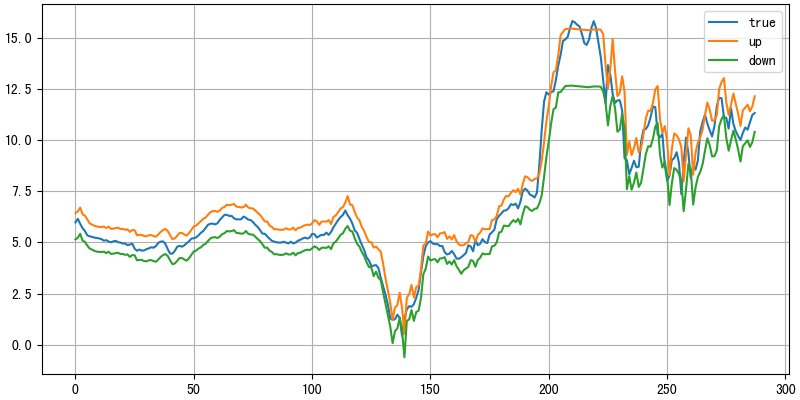

In [159]:

fig, ax = plt.subplots(figsize=(8, 4), layout='constrained')
ax.plot(y_test, label='true')
ax.plot(up, label='up')
ax.plot(down, label='down')
ax.grid()
ax.legend()
plt.show()

In [160]:
PICP = 0
for idx, true in enumerate(y_test):
    if true >= down[idx] and true <= up[idx]:
        PICP+=1
PICP = (PICP / y_test.shape[0]) * 100
PICP

87.84722222222221